In [200]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from networkx import draw
plt.style.use("ggplot")

# Optimal River crossing
## Problem Statement
Given a river of width $d$ and a boat with speed $v_{b}$ how can you cross the river 
in the shortest time possible? The river has a current that varies with the distance
from the shore. It is given by $v_{w}(y)$ where $y$ is the distance
from the starting shore. Usually the current is stronger in the middle of the river
and weaker near the shore and will assume here that it is 
symmetric about the middle of the river, i.e. $v_{w}(y) = v_{w}(d-y)$.

The river has a current of speed $v_{w}(.)$ that is depen $y$ from the shore. 

We want to find the path that minimizes the time to cross the river and reach 
the point opposite the starting point.

## Parametric representation of the path
This problem can is in principle solved by calculus of variations.
However, this is a bit complicated. We will use a simpler approach
that is based on the parametric representation of the path.

We will assume that the x-coordinate gives the distance from the starting point 
along the river and the y-coordinate gives the perpendicular distance from the 
starting shore. 

We will then split the path into $n$ segments and for each of the 
segments we define the boat to move a distance of $\Delta y = \frac{d}{n}$
in the y-direction. 

The path is then defined by the angles $\alpha_{i}$ that the boat makes with the x-axis
at each of the points $y_{i} = i \Delta y$.

Given the angles $\alpha_{i}$ we can then calculate the x and y coordinates of the boat
at each of the points $y_{i}$. We first use the angle $\alpha_{i}$ and the boat speed $v_{b}$
to calculate the time it takes to move from $y_{i}$ to $y_{i+1}$. We then use the time
to calculate the movement of the boat in the x-direction. 

\begin{align}
\Delta t_i &= \frac{\Delta y}{v_{b} \sin(\alpha_i)} \\
\Delta x_i &= v_{b} \cos(\alpha_i) \Delta t_i
\end{align}

The total time to cross the river is then given by the sum of the times for each of the segments: 

\begin{align}
T = \sum_{i=0}^{n-1} \Delta t_i
\end{align}

## Optimization
We want to find the angles $\alpha_{i}$ that minimize the time to cross the river.
Given that we don't want to drift we need to make sure that the boat ends up at the
same x-coordinate as the starting point. This results in a constrained optimization problem:

\begin{align}
\min_{\alpha_i} T =&  \sum_{i=0}^{n-1} \Delta t_i =
\sum_{i=0}^{n-1} \frac{\Delta y}{v_{b} \sin(\alpha_i)} \quad \text{ s.t. } \\

\sum_{i=0}^{n-1} \Delta x_i =& \sum_{i=0}^{n-1} v_{b} \cos(\alpha_i) \Delta t_i = 0.
\end{align}

## Parameters
For the current profile we will use a parabolic profile that is symmetric about the middle of the river, 

\begin{align}
v_{w}(y) = v_{w}(d-y) = (v_{w0} - v_{w1}) \frac{4 y (d-y) }{d^2} + v_{w1}, 
\end{align}
where v_{w0} is the current in the middle of the river (fastest point) and $v_{w1}$ is the current near the shore.

Text(0, 0.5, 'Water speed')

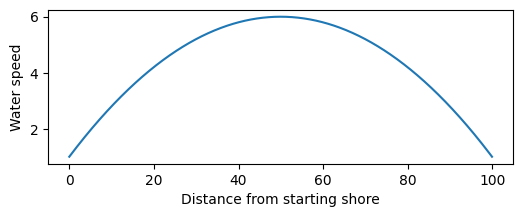

In [80]:
def parabolic_water_speed(y, d, v_water0, v_water1):
    return (v_water0 - v_water1)  *  y * (d - y) / (d**2 / 4) + v_water1

# The step sizes start at y=0 and stop at d-\Delta y so we form the average 
# speed along the travelled y distance using an integral of the water speed
# to assure symmetry

def ind_integral(y, d, v_water0, v_water1):
    return (v_water0 - v_water1) * (d * y**2 / 2 - y**3 / 3) / (d**2 / 4) + v_water1 * y

def mean_water_speed(y0, delta_y, d, v_water0, v_water1):
    return (ind_integral(y0 + delta_y , d, v_water0, v_water1) - ind_integral(y0, d, v_water0, v_water1)) / delta_y

d = 100
n = 1000
v_water0 = 6
v_water1 = 1
delta_y = d / n
ys = np.arange(0, d, delta_y)
vs = mean_water_speed(ys, delta_y, d, v_water0, v_water1)
plt.figure(figsize=(6,2))
plt.plot(ys, vs)
plt.xlabel('Distance from starting shore')
plt.ylabel('Water speed')

In [70]:
def calculate_path(alpha_deg, v_boat=10, n=1000, d=100, v_water0=6, v_water1=1, x_goal=0):
    delta_y = d / n
    ys = np.arange(0, d, delta_y)

    v_water = mean_water_speed(ys, delta_y, d, v_water0, v_water1)

    v_y = v_boat * np.sin(np.radians(alpha_deg))
    v_x = v_boat * np.cos(np.radians(alpha_deg))
    
    delta_ts = delta_y / v_y
    delta_xs = (v_x - v_water) * delta_ts
    
    total_time = np.sum(delta_ts) 

    xs = np.concatenate([[0], np.cumsum(delta_xs)])
    ys = np.concatenate([ys, [d]])
    v_water = np.concatenate([v_water, [v_water1]])

    return {
        "xs": xs,
        "ys": ys,
        "total_time": total_time,
        "v_water": v_water,
        "v_boat": v_boat,
        "delta_xs": delta_xs,
        "alphas": alpha_deg
    }


In [207]:
from functools import lru_cache, partial

@lru_cache(maxsize=None)
def optimize_path(v_boat, v_water0, v_water1, n, drift, epsilon):
    opt_calc_path = partial(calculate_path, n=n, v_boat=v_boat, v_water0=v_water0, v_water1=v_water1)
    
    def objective_function(alpha_deg):
        res = opt_calc_path(alpha_deg)
        return res["total_time"]

    def constraint_function(alpha_deg, drift=0):
        res = opt_calc_path(alpha_deg)
        return np.sum(res["delta_xs"]) - drift
    
    eps0 = 70
    x0 = np.random.uniform(eps0, 180-eps0, n)
    result = minimize(
        objective_function,
        x0=x0,
        bounds=[(epsilon, 180-epsilon)],
        options={"maxiter": 1_000},
        # method="SLSQP",
        constraints={"type": "eq", "fun": partial(constraint_function, drift=drift)},
        # tol=1e-15
    )
    
    print(constraint_function(result.x, drift=drift))
    
    opt_path = opt_calc_path(result.x)
    return opt_path    

In [336]:
def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    p = mpatches.FancyArrow(
        0, 0.5 * height, width, 0, length_includes_head=True, head_width=0.75 * height
    )
    return p

def draw_boat_arrows(opt_path, ax):
    # draw vectors for the velocity
    x_scale = ax.get_xlim()[1] - ax.get_xlim()[0]
    y_scale = ax.get_ylim()[1] - ax.get_ylim()[0]
    
    label = "Boat direction"
    for i in range(0, len(opt_path["xs"]) - 5, 5):
        boat_arrow = ax.arrow(
            opt_path["xs"][i],
            opt_path["ys"][i],
            0.07 *  np.cos(np.radians(opt_path["alphas"][i])) * x_scale,
            0.07 *  np.sin(np.radians(opt_path["alphas"][i])) * y_scale,
            head_width=0.005 * np.sqrt(x_scale**2 + y_scale**2),
            head_length=0.01 * np.sqrt(x_scale**2 + y_scale**2),
            color="red",
            label=label,
        )
        label = None
        
def draw_water_land(ax, x_lims=None, y_lims=None, land_height=15):
    # x_lims = x_lims or ax.get_xlim()
    x_lims = ax.get_xlim()
    y_lims = y_lims or ax.get_ylim()

    # draw water
    ax.add_patch(
        mpatches.Rectangle(
            (x_lims[0], y_lims[0]), x_lims[1] - x_lims[0], y_lims[1] - y_lims[0], edgecolor="black", facecolor="blue", alpha=0.2
        )
    )
            
    # draw land
    ax.add_patch(
        mpatches.Rectangle(
            (x_lims[0], y_lims[0]), x_lims[1] - x_lims[0], -land_height, edgecolor="black", facecolor="green", alpha=0.2
        )   
    )
    
    ax.add_patch(
        mpatches.Rectangle(
            (x_lims[0], y_lims[1]), x_lims[1] - x_lims[0], land_height, edgecolor="black", facecolor="green", alpha=0.2
        )
    )   
    return x_lims, y_lims 

def plot_path(opt_path, x_lims=None, y_lims=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), width_ratios=[2, 1], sharey=True)
    if x_lims:
        axes[0].set_xlim(x_lims)
    # axes[0].set_ylim(y_lims)
    boat_path = axes[0].plot(
        opt_path["xs"], opt_path["ys"], label="Boat path", color="blue"
    )

    draw_boat_arrows(opt_path, axes[0])
    
    # keep y_lims for the second plot as drawing changes them    
    _, y_lims = draw_water_land(axes[0])

    # ---------------------- Water speed plot ----------------------
    water_speed = -opt_path["v_water"] * 3.6
    axes[1].plot(
        water_speed, opt_path["ys"], label="Water speed", color="blue"
    )

    for i in range(0, len(opt_path["ys"]) - 5, 5):
        arrow_length = water_speed[i]
        head_length = 0.1
        axes[1].arrow(
            water_speed[i] - arrow_length + head_length,
            opt_path["ys"][i],
            arrow_length,
            0,
            head_width=3,
            head_length=head_length,
            color="blue",
        )

    draw_water_land(axes[1], y_lims=y_lims)

    plt.tight_layout()
    plt.ylim(-15, 115)
    axes[0].set_ylabel("Distance across [m]")
    axes[0].set_xlabel("Distance along [m]")
    axes[0].legend(
        handler_map={mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow)}, 
        loc="center left"
    )

    axes[1].set_xlabel("Speed [km/h]")
    axes[1].legend()
    # set figure title and shift it upwards
    ttc = opt_path["total_time"] 
    bs = opt_path["v_boat"] * 3.6
    drift = opt_path["xs"][-1]
    plt.suptitle(f"Time to cross {ttc:.0f}s. Boat speed {bs:.2f} km/h. Drift {drift:.2f} m", y=1.02)

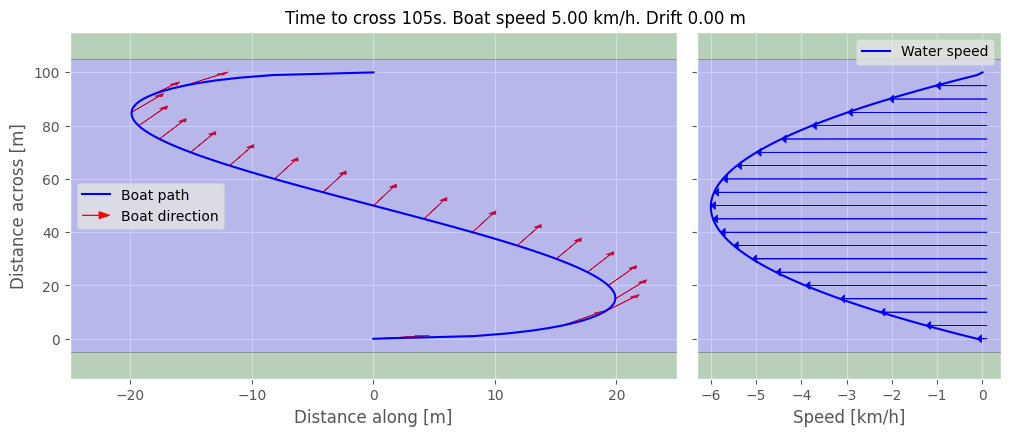

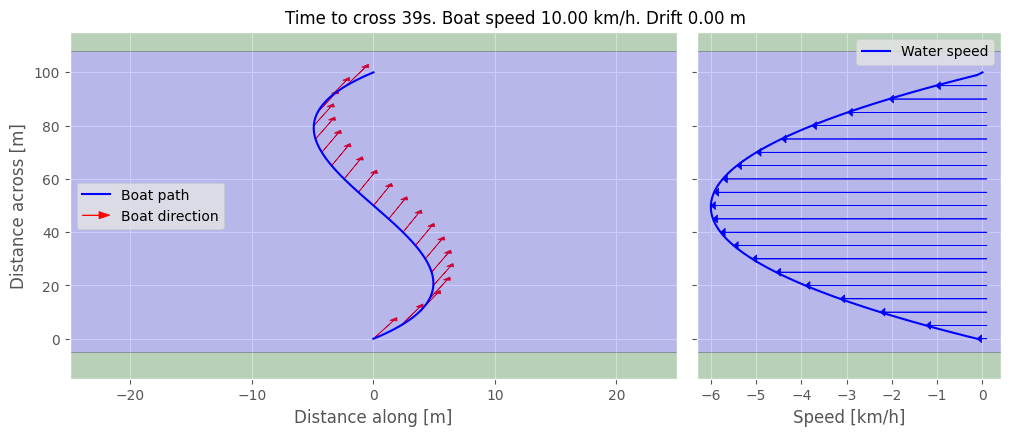

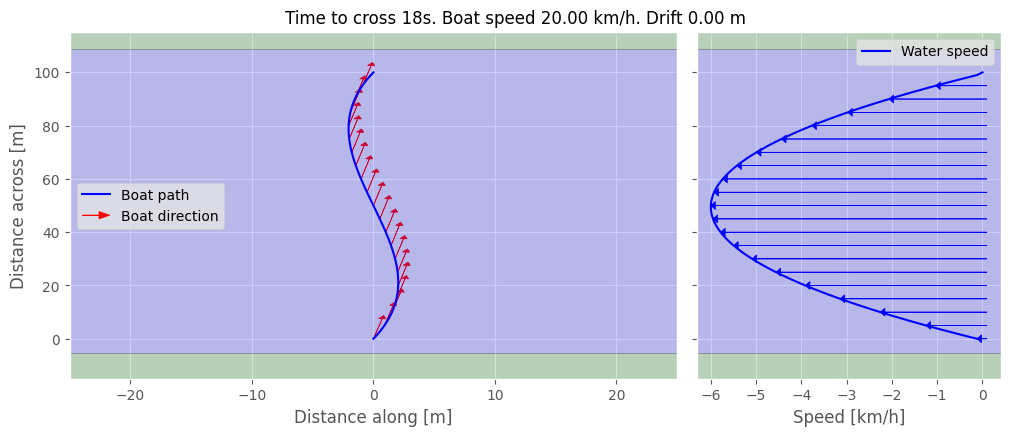

In [339]:
# slow boat
settings_0 = {
    "v_boat": 5 / 3.6,
    "v_water0": 6 / 3.6,
    "v_water1": 0 / 3.6,
    "n": 100,
    "drift": 0,
    "epsilon": 1e-3
}

# fast boat
settings_1 = settings_0.copy()
settings_1["v_boat"] = 10 / 3.6

settings_2 = settings_0.copy()
settings_2["v_boat"] = 20 / 3.6

for settings in [settings_0, settings_1, settings_2]:
    settings = settings.copy()
    opt_path = optimize_path(**settings)
    plot_path(opt_path, x_lims=(-25, 25))

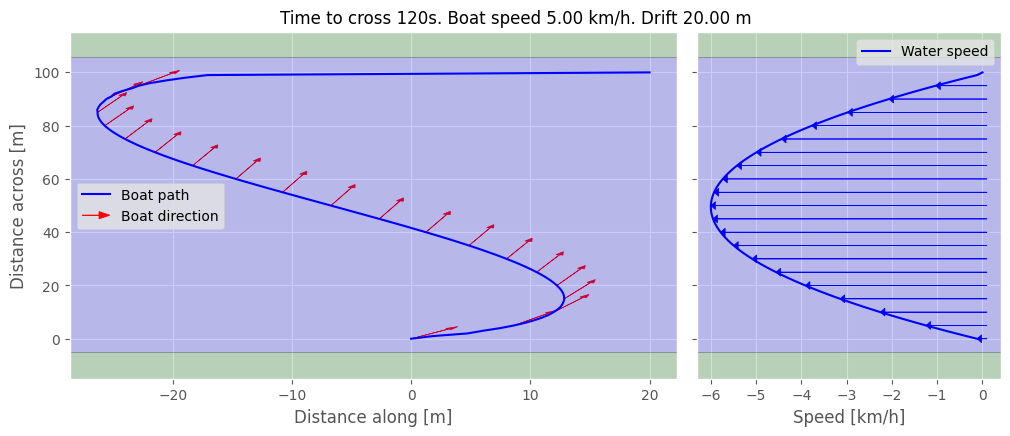

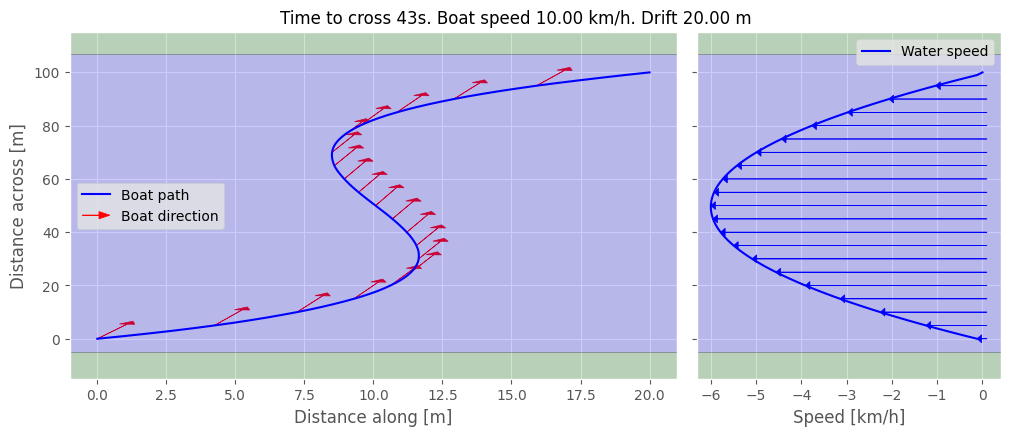

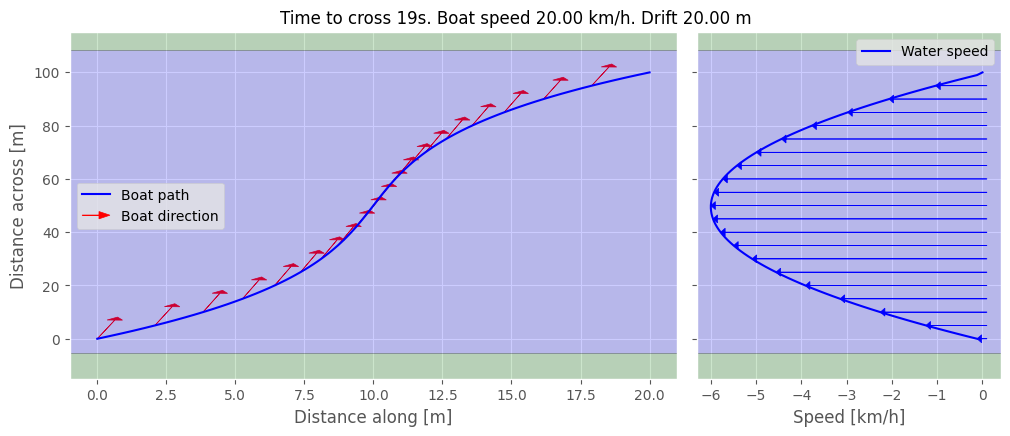

In [343]:
for settings in [settings_0, settings_1, settings_2]:
    settings = settings.copy()
    settings["drift"] = 20
    opt_path = optimize_path(**settings)
    plot_path(opt_path)

In [ ]:
settings = settings_0.copy()

boat_speeds = np.arange(2, 20, 1) / 3.6
cross_times = []
for boat_speed in boat_speeds:
    settings["v_boat"] = boat_speed
    opt_path = optimize_path(**settings)
    cross_times.append(opt_path["total_time"])

from cProfile import label
import pandas as pd
# cross_times = pd.to_timedelta(cross_times, unit="s")
print(cross_times)
import seaborn as sns
data = pd.DataFrame({"Boat speed [km/h]": boat_speeds * 3.6, "Cross time [s]": cross_times})
sns.lineplot(data, x="Boat speed [km/h]", y="Cross time [s]")
plt.plot(boat_speeds * 3.6, 100/boat_speeds, label="Time as the crow flies")
plt.legend()